# Описание проекта

Требуется построить модель, которая будет предсказывать нагрузку на сервис такси в определенных местах на ближайший час\
Имеется CSV временного ряда\
Примерный ход работ:
- Подготовка данных
- Ресемплинг
- Декомпозиция
- Визуализация
- Проверка на стационароность
- Подготовка признаков
- Исследование моделей
- Сравнение с прогнозом по историческим данным (прямой)
- Формулировка общего вывода

# Импорты

In [1]:
from math import sqrt

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from prophet import Prophet
from prophet.diagnostics import cross_validation

# Пользовательские функции

In [2]:
#  Функция для первичного анализа дата-сета
def analyze_df(df):
    # выводим размерность датафрейма
    display("Размерность датафрейма:")
    display(df.shape)

    
    # выводим информацию о датафрейме
    display("Информация о датафрейме:")
    display(df.info())

    
    # выводим статистическую информацию о датафрейме
    display("Статистическая информация о датафрейме:")
    display(df.describe())
    

    # выводим первые 10 строк датафрейма
    display("Первые 10 строк датафрейма:")
    display(df.head(10))


In [3]:
#  Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    ts = data.copy()
    ts['month'] = ts.index.month
    ts['day'] = ts.index.day
    ts['dayofweek'] = ts.index.dayofweek
    ts['hour'] = ts.index.hour
    for lag in range(1, max_lag + 1):
        ts['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    ts['rolling_mean'] = ts['num_orders'].shift().rolling(rolling_mean_size).mean()
    return ts

# Загрузка файлов

In [4]:
#  Сохраним файлы в стандартную переменную, используя оба источника
try:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Подготовка данных

In [5]:
analyze_df(data)

In [6]:
#  Проверка на монотонность индекса
data.index.is_monotonic_increasing

In [7]:
#  Resampling
data = data.resample('1H').sum()

In [8]:
#  Декомпозиция данных
decomposed = seasonal_decompose(data)
trend = decomposed.trend # трендовая составляющая
seasonal = decomposed.seasonal # сезонная составляющая
resid = decomposed.resid # остаток декомпозиции

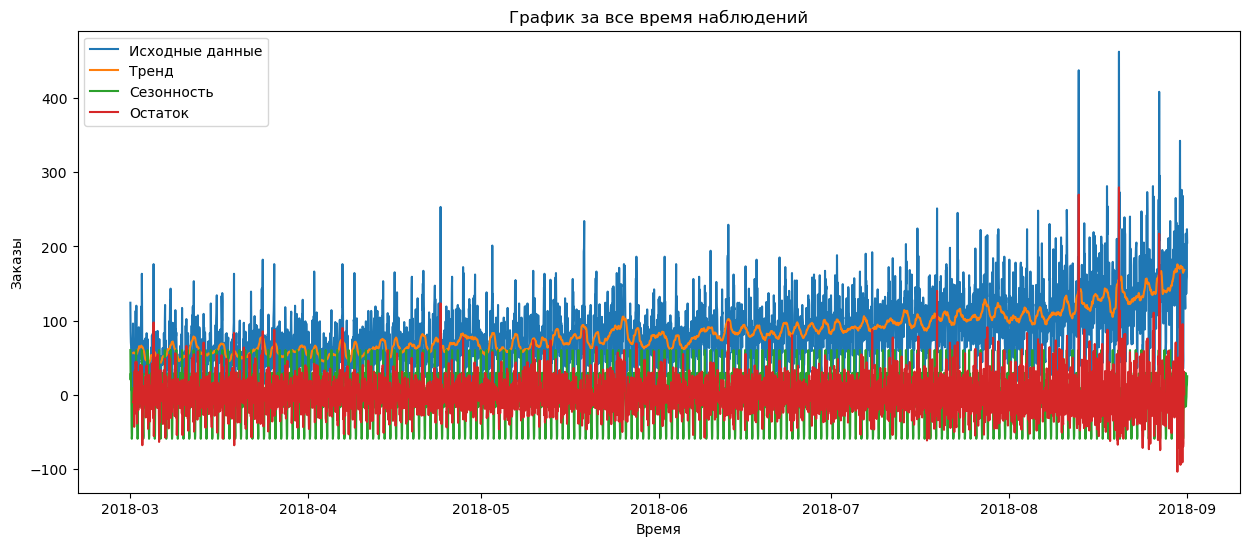

In [9]:
#  Визуализация данных
plt.figure(figsize=(15, 6))
plt.plot(data, label='Исходные данные')
plt.plot(trend, label='Тренд')
plt.plot(seasonal, label='Сезонность')
plt.plot(resid, label='Остаток')
plt.legend()

#  Настройка осей и заголовка
plt.xlabel('Время')
plt.ylabel('Заказы')
plt.title('График за все время наблюдений')

#  Отображение графика
plt.show()


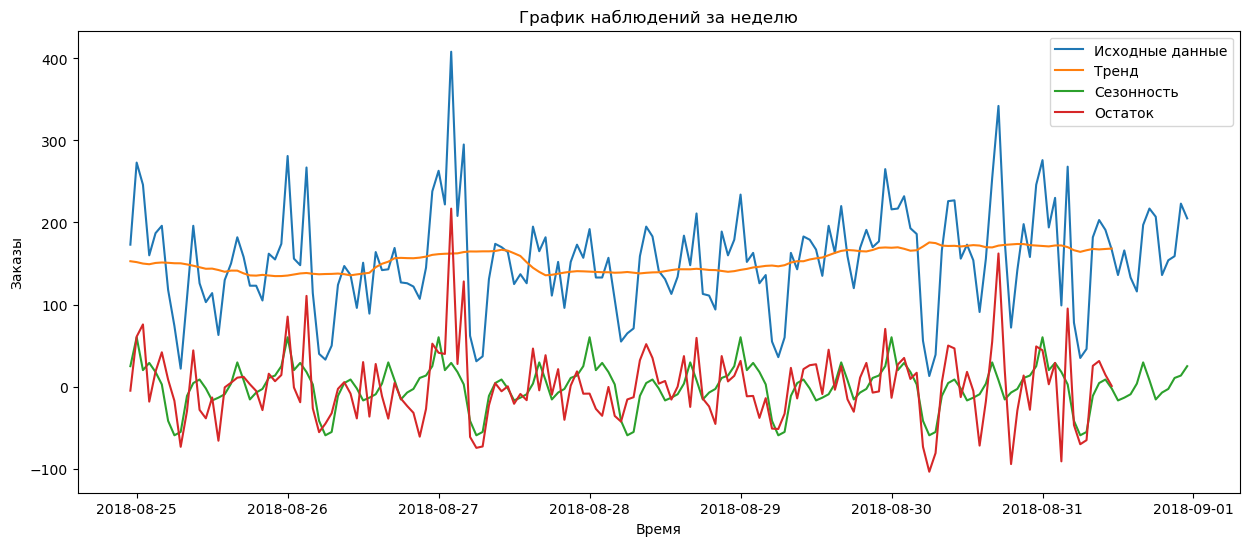

In [10]:
#  Определение начальнуой и конечной даты для отображения (за неделю)
end_date = pd.to_datetime('2018-08-31 23:00:00')
start_date = end_date - pd.DateOffset(weeks=1)

#  Фильтрация данных только за выбранный период
data_week = data[(data.index >= start_date) & (data.index <= end_date)]
trend_week = trend[(trend.index >= start_date) & (trend.index <= end_date)]
seasonal_week = seasonal[(seasonal.index >= start_date) & (seasonal.index <= end_date)]
resid_week = resid[(resid.index >= start_date) & (resid.index <= end_date)]

#  Визуализация данных
plt.figure(figsize=(15, 6))
plt.plot(data_week, label='Исходные данные')
plt.plot(trend_week, label='Тренд')
plt.plot(seasonal_week, label='Сезонность')
plt.plot(resid_week, label='Остаток')
plt.legend()

#  Настройка осей и заголовка
plt.xlabel('Время')
plt.ylabel('Заказы')
plt.title('График наблюдений за неделю')

#  Отображение графика
plt.show()


In [11]:
def seasonal_and_trend_plot(seasonal, trend, start_date, end_date):
    # Выбор подотрезка ['start_date':'end_date'] для сезонной составляющей
    selected_seasonal = seasonal[start_date:end_date]
    
    # Выбор подотрезка ['start_date':'end_date'] для трендовой составляющей
    selected_trend = trend[start_date:end_date]

    # Создание подграфиков
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # График сезонной составляющей
    ax1.plot(selected_seasonal)
    ax1.set_title('Сезонная составляющая ({} - {})'.format(start_date, end_date))
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Значение')
    ax1.grid(True)
    
    # График трендовой составляющей
    ax2.plot(selected_trend)
    ax2.set_title('Трендовая составляющая ({} - {})'.format(start_date, end_date))
    ax2.set_xlabel('Дата')
    ax2.set_ylabel('Значение')
    ax2.grid(True)
    
    # Размещение графиков
    plt.tight_layout()
    plt.show()


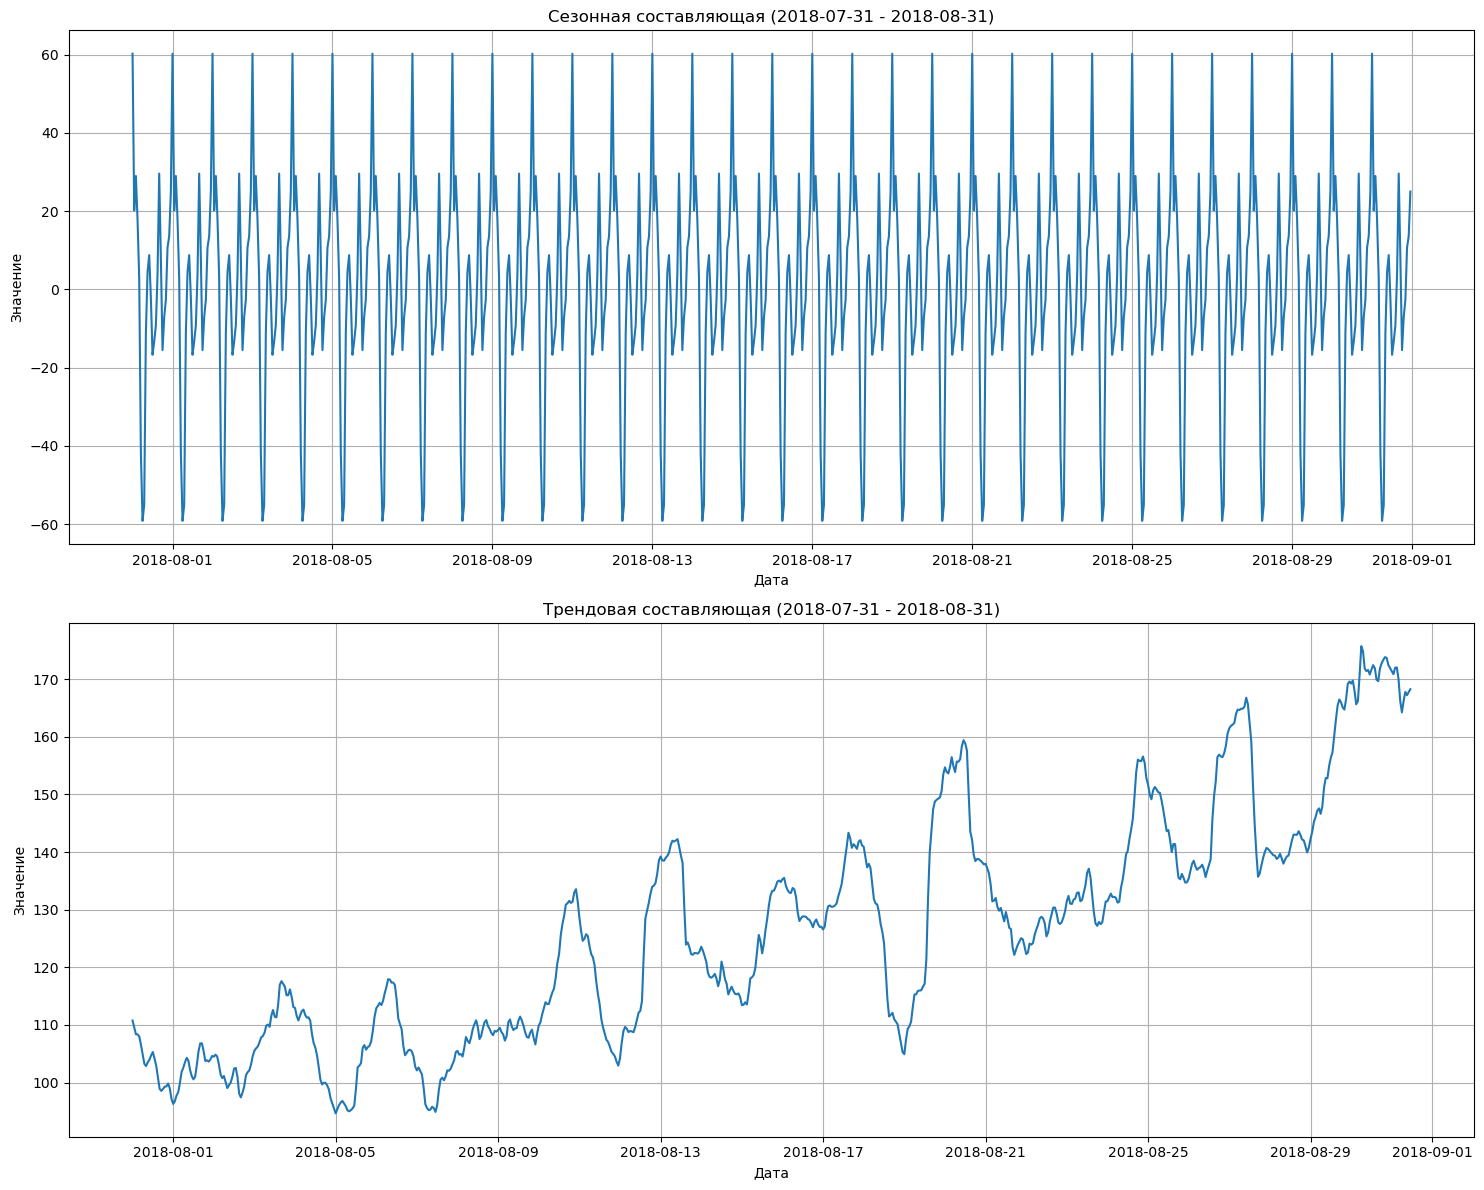

In [12]:
seasonal_and_trend_plot(seasonal, trend, '2018-07-31', '2018-08-31')

# Проверка ряда на стационарность

In [13]:
# Тест Дики - Фуллера
result_adf = adfuller(data)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:', result_adf[4])

In [14]:
# Тест КПСС
result_kpss = kpss(data)
print('KPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])
print('Critical Values:', result_kpss[3])

In [15]:
# Применим отстающее значение и скользящее среднее рвное 8 часам (стандартная рабочая смена)
ts = make_features(data, 16, 16)

## Вывод о подготовке данных

Предоставленные данные - монотонные (не прерываются)\
Временной ряд, с большой вероятностью, является стационарным \
Был проведен ресемплинг данных по сумме значений\
Была проведена декомпозиция данных на: тренд, сезонность и остаток (шум)\
Время установлено в качестве индекса\
Были созданы "отстающие" признаки и скользящее среднее\
Построенны графики наблюдений за неделю и за все время

# Обучение

In [16]:
#  Деление на выборки в соотношении 9:1
train, test = train_test_split(data, test_size=0.1, shuffle=False, random_state=123)
val, test = train_test_split(train, test_size=0.1, shuffle=False, random_state=123)

#  Проверка выборок
display(train.shape, test.shape)

In [17]:
# Объявление признаков
features_train = train.drop(['num_orders'], axis =1)
target_train = train['num_orders']
features_val = val.drop(['num_orders'], axis =1)
target_val = val['num_orders']
features_test = test.drop(['num_orders'], axis =1)
target_test = test['num_orders']

In [18]:
#  Деление на выборки в соотношении 9:1
ts_train, ts_test = train_test_split(ts, test_size=0.1, shuffle=False, random_state=123)
ts_val, ts_test = train_test_split(ts, test_size=0.1, shuffle=False, random_state=123)

#  Проверка выборок
display(ts_val)

In [19]:
# Объявление признаков
ts_features_train = ts_train.drop(['num_orders'], axis =1).dropna()
ts_target_train = ts_train.iloc[len(train)-len(ts_features_train):]['num_orders']
ts_features_val = ts_val.drop(['num_orders'], axis =1).dropna()
ts_target_val = ts_val.iloc[len(ts_val)-len(ts_features_val):]['num_orders']
ts_features_test = ts_test.drop(['num_orders'], axis =1)
ts_target_test = ts_test['num_orders']

display(ts_features_val.shape, ts_target_val.shape)

In [20]:
# Создание метрики качества RMSE с помощью Лямбда-функции
scoring = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)

## Linear Regression

In [21]:
# 
lr_params_dist = {
    #'normalize': [True, False],
    'fit_intercept':[True,False],
}

#  Создание объекта линейной регрессии
lr = LinearRegression(n_jobs=-1)

grid_search = GridSearchCV(lr, lr_params_dist, scoring=scoring, n_jobs=-1)
grid_search.fit(ts_features_train, ts_target_train)
best_model = grid_search.best_estimator_
best_predict = best_model.predict(ts_features_val)
best_rmse = np.sqrt(mean_squared_error(ts_target_val, best_predict))
print(best_rmse)

## ARIMA

In [22]:
# Автоматический подбор гиперпараметров
arima = pm.auto_arima(train, n_jobs=-1, random_state=123, seasonal=True)

# Обучение модели
results = arima.fit(train)

# Получение прогнозов
arima_forecast = results.predict(n_periods=len(val))

# RMSE
arima_rmse = np.sqrt(mean_squared_error(val, arima_forecast))

print(arima_rmse)
print(arima.order)

In [23]:
# Подбор гиперпараметров ARIMA с помощью поиска по сетке
model = pm.auto_arima(train, start_p=1, start_q=1,
                      max_p=9, max_q=9, seasonal=False,
                      trace=True, error_action='ignore', suppress_warnings=True)

# Получение прогноза
forecast = model.predict(len(val))

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(val, forecast))
print('RMSE:', rmse)

# Вывод результатов подбора гиперпараметров
print(model.summary())

## Prophet

В соответствии с Бритвой Оккама для данной модели написана своя функция.\
Код почти повторяет предыдущую работу за исключением некоторых нюансов, которые не стоит выводить в глобальную область.\
Функция будет возвращать модель и значение искомой метрики (RMSE)

In [24]:
def forecast_prophet_cv(url):
    # Загрузка CSV-файла по ссылке
    df = pd.read_csv(url)

    # Переименование столбцов в соответствии с требованиями Prophet
    df = df.rename(columns={'datetime': 'ds', 'num_orders': 'y'})

    # Преобразование столбца с датами в нужный формат
    df['ds'] = pd.to_datetime(df['ds'])

    # Ресемплинг данных по 1 часу по сумме заказов
    df = df.resample('1H', on='ds').sum().reset_index()

    # Разделение на тренировочную и тестовую выборки в пропорции 9 к 1
    train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)

    prophet_param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range' : [0.5, 1]
    }

    # Создание и обучение модели Prophet
    prophet = Prophet()
    prophet.fit(train_df)

    # Проведение кросс-валидации
    cv_results = cross_validation(prophet, horizon='1 day')
    
    # Лучшие гиперпараметры
    prophet_best_params = np.argmin(rmse)

    # Прогнозирование на тестовой выборке
    forecast = prophet.predict(test_df)

    # Вычисление метрик на основе результатов кросс-валидации
    prophet_rmse = np.sqrt(mean_squared_error(cv_results['y'], cv_results['yhat']))

    # Визуализация графиков (актуального и прогноза Prophet)
    fig1 = prophet.plot(forecast)

    ax = (df.plot(x='ds',y='y',figsize=(15,8),title='Actual Vs Forecast'))
    forecast.plot(x='ds',y='yhat',figsize=(15,8),title='Actual vs Forecast', ax=ax)

    # Возвращаем модель и значение метрики
    return prophet_rmse, prophet, prophet_best_params, forecast

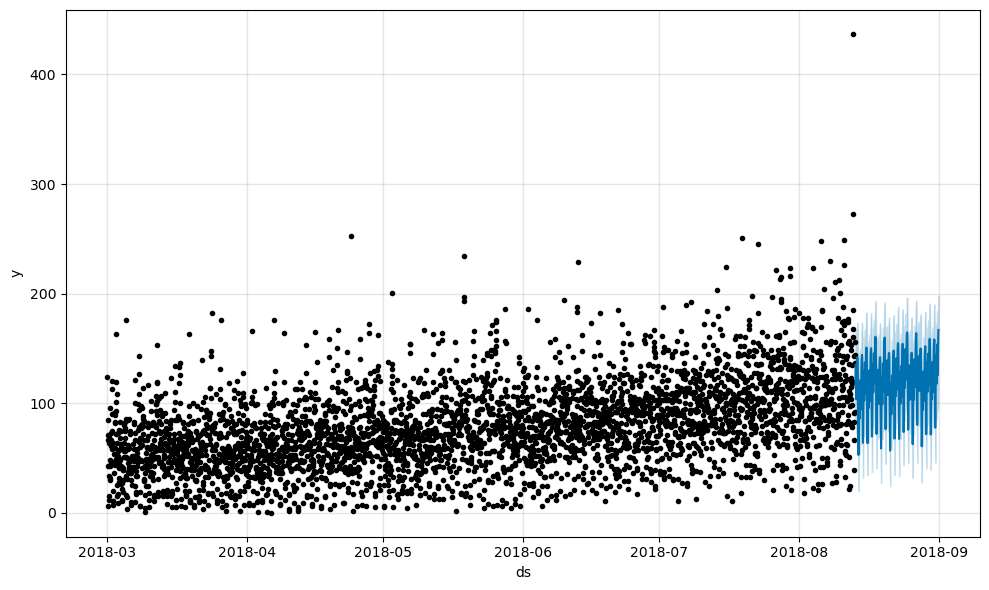

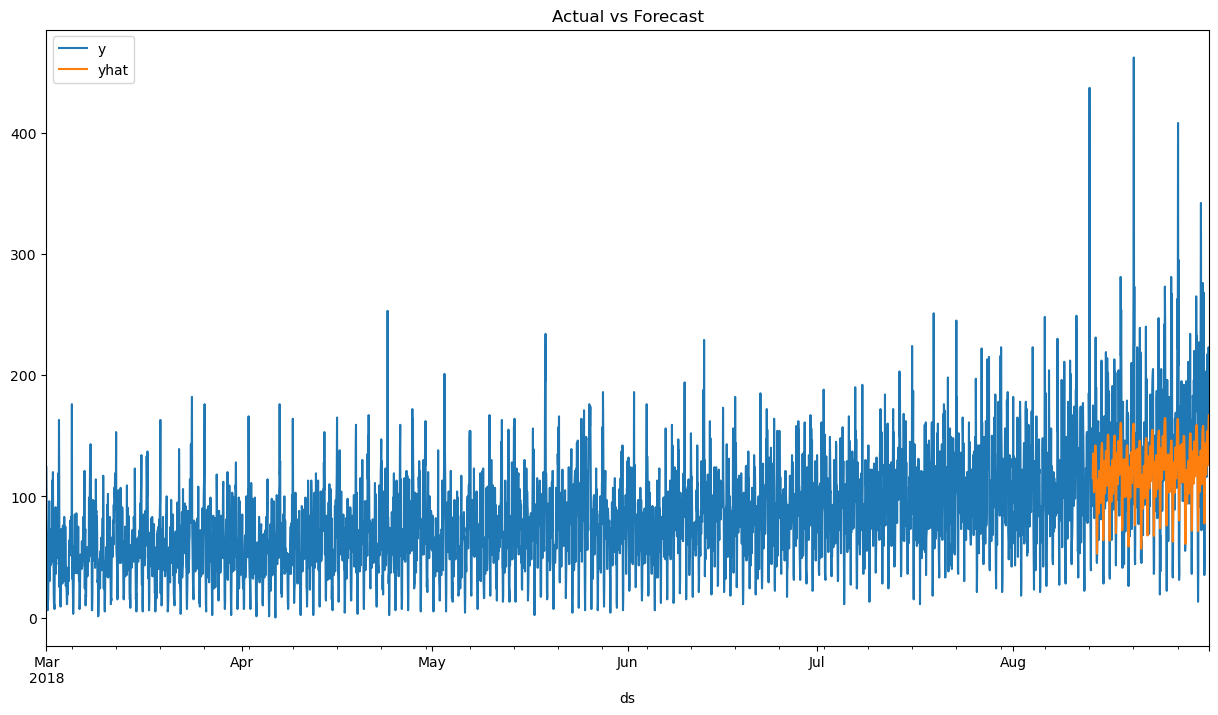

In [25]:
forecast_prophet_cv('https://code.s3.yandex.net/datasets/taxi.csv')

In [26]:
# Прогноз модели по историческим данным (Дамми тест)
pred_by_previous = np.ones(test.shape)*test.shift(fill_value = train.iloc[-1]['num_orders'])
print("RMSE:", np.sqrt(mean_squared_error(test, pred_by_previous)))

# Вывод

В данном проекте было выполнено:
- Предобработка данных
- Ресемплинг по 1 часу и сумме значений
- Протестированы 3 модели МО
Лучший результат выдала библиотека Prophet. RMSE составил 24,9. Для нее была составлена своя функция\
На втором месте Линейная регрессия с результатом 52. Замыкает лидер-борд модель ARIMA со значением RMSE 62\
Были использованы библиотеки с автоматическим подбором гиперпараметров, так что в ручную ничего не настраивалось\
Но если учитывать проверку на адекватность в виде прогноза по историческим данным, то тест преодолели 2 модели (Prophet и Линейная регрессия)\